### Faiss Library
 - Faiss is a library for efficient similarity search and clustering of dense vectors.
 - It contain algorithms that search in sets of vectors of any size, up to one that possibly do not fint in RAM.
 - Faiss is written in c++ with compelete wrappers for Python  / numpy.
 - Compared with L2 (Euclidean) distance or dot products.

### Basic Image Search Code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

### Import the libraries

In [4]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist

### Pre-Trained ResNet-50 Model

In [7]:
### Pre-Trained ResNet-50 Model
# Created a class named ResNetFreezed and uses the pretrained model

backbone = 'resnet50'

class ResNetFreezed(nn.Module):
  def __init__(self, freeze_param = True):
    super(ResNetFreezed, self).__init__()
    if backbone =='resnet34':
      self.backbone = torchvision.models.resnet34(pretrained=True)

    if backbone =='resnet50':
      self.backbone = torchvision.models.resnet50(pretrained=True)

    if backbone =='resnet101':
      self.backbone = torchvision.models.resnet101(pretrained=True)

    state_dict = self.backbone.state_dict() # Here, pretrained model state paased to state_dict variable
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-1]) # pass all layers except the last obe to backbone

    if freeze_param:
      for param in self.backbone.parameters():
        param.requires_grad = False

  def forward(self, x):
    x = self.backbone(x)
    out = torch.flatten(x, 1)
    return out


### Evaluation Mode

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Pass the buil ResNetFreezed model into model variable and applied the device CPU/GPU
model  = ResNetFreezed().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [13]:
model.eval() # show the evaluation of model

ResNetFreezed(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

### Classes

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Data Loader

In [16]:
batch_size = 32
mean = (0.4914, 0.4822, 0.4465)
std  = (0.4914, 0.4822, 0.4465)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
)


def de_normalized(image):
  image = (image * 0.5) + 0.5  # de-normalized
  np_image = image.numpy()
  np_image = np.transpose(np_image, (1,2,0))
  return np_image

train_dataset = torchvision.datasets.CIFAR10(root = 'gdrive/MyDrive/data/cifar-10',
                                            train=True,
                                            download = True,
                                            transform = transform
                                            )

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size =batch_size,
                                           shuffle = True,
                                           num_workers = 0
                                           )

100%|██████████| 170498071/170498071 [00:01<00:00, 102267194.25it/s]


Extracting gdrive/MyDrive/data/cifar-10/cifar-10-python.tar.gz to gdrive/MyDrive/data/cifar-10


### Save the Embedding

In [17]:
dataFrame_vector = pd.DataFrame()
for batch_index, (images, labels) in enumerate(train_loader):
  feats = model(images.to(device)).detach().cpu()
  for i, f in enumerate(feats):
    dataFrame_vector = dataFrame_vector.append({'vec':f.detach().numpy(), 'label': labels[i]}, ignore_index=True)



Streaming output truncated to the last 5000 lines.
<ipython-input-17-0138c15c4bbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataFrame_vector = dataFrame_vector.append({'vec':f.detach().numpy(), 'label': labels[i]}, ignore_index=True)
<ipython-input-17-0138c15c4bbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataFrame_vector = dataFrame_vector.append({'vec':f.detach().numpy(), 'label': labels[i]}, ignore_index=True)
<ipython-input-17-0138c15c4bbd>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataFrame_vector = dataFrame_vector.append({'vec':f.detach().numpy(), 'label': labels[i]}, ignore_index=True)
<ipython-input-17-0138c15c4bbd>:5: FutureWarning: The frame.append method is deprecated and will be removed f

In [18]:
dataFrame_vector.iloc[0].vec.shape

(2048,)

In [21]:
#dataFrame_vector = pd.read_pickle('/content/gdrive/MyDrive/data/cifar-10/cifar-10-python.tar.gz')
print(len(dataFrame_vector))

50000


### Query and visualization
 - Search Top 5
 - if you can reduce your target search sparce it will be faster cluster search.

torch.Size([1, 2048])


[3.22235697e+01 4.37701380e-05 3.50177565e+01 3.55924754e+01
 3.51650991e+01]


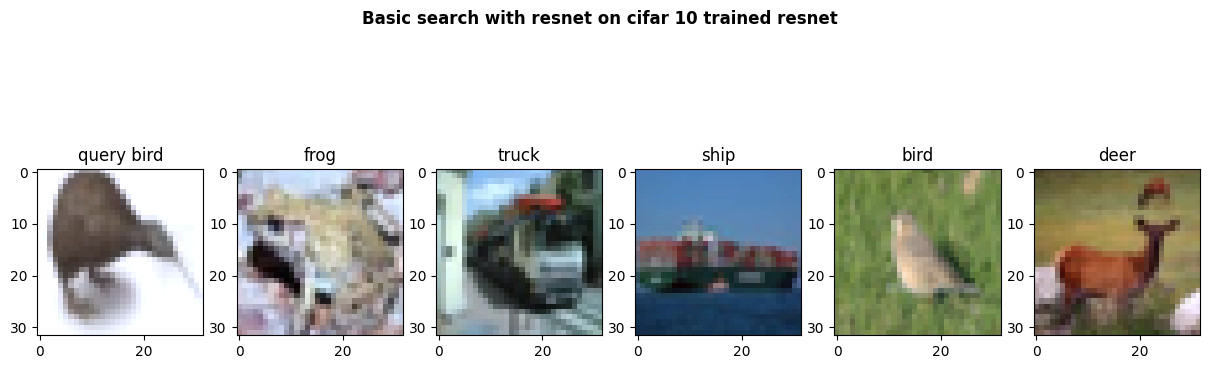

In [23]:
target_idx = random.randint(0,len(train_dataset))
target = train_dataset[target_idx][0]
target_label = classes[train_dataset[target_idx][1]]
target_tensor = torch.unsqueeze(train_dataset[target_idx][0], 0).to(device)

feat = model(target_tensor).detach().cpu()
print(feat.shape)
top_n = 5
dist = cdist(feat, list(dataFrame_vector.vec), 'euclidean')[0]
ind = np.argpartition(dist, top_n)[0:top_n]

print(dist[ind])

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Basic search with resnet on cifar 10 trained resnet', fontweight ="bold")
no_of_images = top_n+1

ax = fig.add_subplot(1, no_of_images, 1)
ax.imshow(de_normalized(target))
ax.set_title('query {}'.format(target_label))

for i in range(1, no_of_images):
    ax = fig.add_subplot(1, no_of_images, i+1)
    ax.imshow(de_normalized(train_dataset[ind[i-1]][0]))
    ax.set_title('{}'.format(classes[train_dataset[ind[i-1]][1]]))